# Amazon Reviews Sentiment Analysis

Author: Ninad Akolekar

## Python Version
This notebook is coded in Python 3.6.9

In [91]:
import sys
print("Python Version")
print(sys.version)

Python Version
3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]


## Download dataset
The dataset we use is the Office Products "core_5" subset of the [Amazon product data](http://jmcauley.ucsd.edu/data/amazon/)

In [92]:
! wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Office_Products_5.json.gz
! gzip -d reviews_Office_Products_5.json.gz

--2020-03-22 10:06:38--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Office_Products_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18507440 (18M) [application/x-gzip]
Saving to: ‘reviews_Office_Products_5.json.gz.1’

reviews_Office_Prod 100%[===================>]  17.65M  3.31MB/s    in 5.6s    

2020-03-22 10:06:44 (3.15 MB/s) - ‘reviews_Office_Products_5.json.gz.1’ saved [18507440/18507440]

gzip: reviews_Office_Products_5.json already exists; do you wish to overwrite (y or n)? n
	not overwritten


In [119]:
# Import required packages

# Python Standard Packages

import re
import pickle

# External Packages

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# For model building
import keras
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Activation, Embedding
from keras.utils import np_utils

# For model selection & evaluation
import sklearn
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split

# For text cleaning & preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk import sent_tokenize, word_tokenize, pos_tag
from bs4 import BeautifulSoup  

# To generate word2vec embeddings
from gensim.models import word2vec, Word2Vec
from gensim.models.keyedvectors import KeyedVectors

# Generating WordClouds
import wordcloud
from wordcloud import WordCloud

nltk.download("punkt")
nltk.download('stopwords')
nltk.download("vader_lexicon")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [94]:
# Versions of external dependencies
print(f"Numpy {np.__version__}")    # 1.18.2
print(f"Pandas {pd.__version__}")   # 0.25.3
print(f"Matplotlib {matplotlib.__version__}")   # 3.2.0
print(f"Seaborn {sns.__version__}") # 0.10.0
print(f" TensorFlow {tf.__version__}")  # 1.15.0
print(f"Kears {keras.__version__}") # 2.2.5
print(f"Sci-kit Learn {sklearn.__version__}")   # 0.22.2.post1
print(f"NLTK {nltk.__version__}")   # 3.2.5
print(f"WordCloud {wordcloud.__version__}") # 1.5.0

Numpy 1.18.2
Pandas 0.25.3
Matplotlib 3.2.0
Seaborn 0.10.0
 TensorFlow 1.15.0
Kears 2.2.5
Sci-kit Learn 0.22.2.post1
NLTK 3.2.5
WordCloud 1.5.0


## Load the Dataset

In [95]:
dataset_path = "reviews_Office_Products_5.json"
data_df = pd.read_json(dataset_path, lines=True)
data_df.sample(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
21927,A3BH63GKL7MQ2K,B002K9IHJK,"J. Roberts ""RP madman""","[0, 0]",These things stick to all the surfaces Post-it...,2,"Not very sticky, not easy to write on, but ver...",1263254400,"01 12, 2010"
20238,A2I05FGBTCRRB8,B00290N0RO,"anon ""anon""","[1, 1]",This is a nice big sketch book. I have been do...,5,excellent,1401062400,"05 26, 2014"
16117,A20EJTAFI1VM5Z,B001B0GH9Q,Eileen Cunningham,"[0, 0]",Our new headmaster this year favors that all o...,5,How Teachers Can Use These Slash Jackets,1328313600,"02 4, 2012"
31915,A1LYT85S93HUNY,B0048LMNP2,Thomas A. Goodwin,"[0, 0]",AT&T; Cordless phoneI bought these as a Christ...,5,Nice Phones work perfectly even with a full ye...,1386633600,"12 10, 2013"
8210,A3P84TZX9X1B3X,B000A6X9CU,KIMBUYS,"[0, 0]",Does a great print job for text and photos. D...,3,"Inconsisently says ""out of paper"" and is an in...",1289174400,"11 8, 2010"


## Understanding the dataset

In [96]:
# Summary of Numerical Features
data_df.describe()

,overall,unixReviewTime
count,53258.000000,5.325800e+04
mean,4.345957,1.340084e+09
std,0.930250,5.266063e+07
min,1.000000,9.701856e+08
25%,4.000000,1.301702e+09
50%,5.000000,1.351728e+09
75%,5.000000,1.387238e+09
max,5.000000,1.406074e+09


We have much more cases of positive reviews as compared to negative reviews, a typical case of imbalanced data.

In [97]:
print("Count of reviews: ",len(data_df))
print("Unique products: ", len(list(set(data_df['asin']))))
print("Fraction of reviews with positive sentiment : {:.2f}".format(data_df[data_df['overall']>3]["reviewText"].count()/len(data_df)))
print("Fraction of reviews with neutral sentiment : {:.2f}".format(data_df[data_df['overall']==3]["reviewText"].count()/len(data_df)))
print("Fraction of reviews with negative sentiment : {:.2f}".format(data_df[data_df['overall']<3]["reviewText"].count()/len(data_df)))

Count of reviews:  53258
Unique products:  2420
Fraction of reviews with positive sentiment : 0.85
Fraction of reviews with neutral sentiment : 0.10
Fraction of reviews with negative sentiment : 0.05


In [98]:
data_df.dropna(inplace=True)    # Drop missing values
data_df = data_df[data_df['overall'] != 3]  # Remove neutral ratings
data_df['Sentiment'] = np.where(data_df['overall'] > 3, 1, 0)   # Encode rating > 3 as 1 (positive) and < 3 as 0 (negative)
data_df.sample(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,Sentiment
30323,A1W60EW7Q6A75C,B003VQ8SCW,"Niki Collins-queen, Author ""author""","[0, 0]","The ""Expo Biggest Loser Daily Meal Planner Mag...",4,Helps to follow the Biggest Loser Exercise Plan,1285977600,"10 2, 2010",1
138,A2AXKUSM1SB5BD,B00002QUKW,"N. Mashmoor ""iko""","[0, 0]",simply very similar to the one that cost 5 tim...,5,works great,1385510400,"11 27, 2013",1
15627,A1ZPD53DH9LFVF,B00191TSI4,AvidReader,"[0, 0]",Good value compared to retail. I've owned HP ...,5,HP comes through again,1361577600,"02 23, 2013",1


In [0]:
# NLTK Vader to understand Sentiment Intensity in the dataset
sid = SentimentIntensityAnalyzer()
data_df["sid_scores"] = data_df["reviewText"].apply(lambda x: sid.polarity_scores(x))
data_df = pd.concat([data_df.drop(['sid_scores'], axis=1), data_df['sid_scores'].apply(pd.Series)], axis=1)

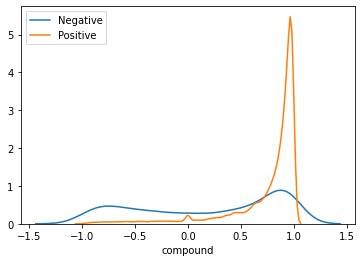

In [100]:
# Density Plot of Compund score from NLTK Vader

for x in [0, 1]:
    data_subset = data_df[data_df['Sentiment'] == x]
    label = "Positive" if x == 1 else "Negative"
    sns.distplot(data_subset['compound'], hist = False, label = label)

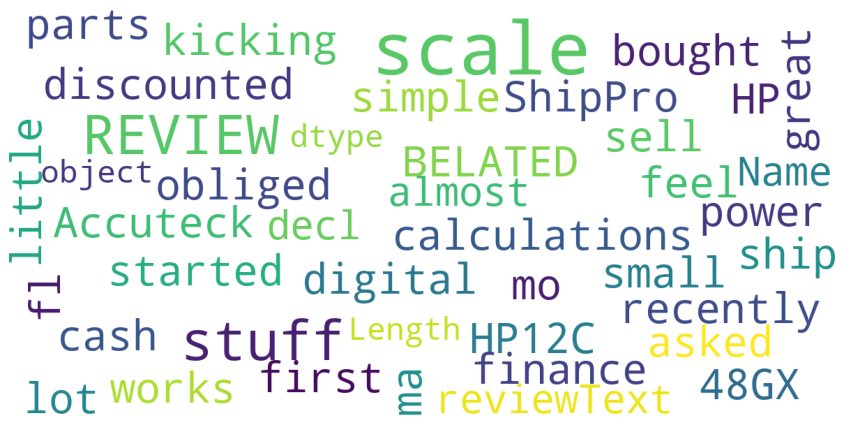

In [101]:
# See what kind of words appear in the dataset

def plot_wordcloud(data):

    wordcloud = WordCloud(random_state = 42,max_words = 200,background_color = 'white',max_font_size = 35,scale = 3)
    wordcloud = wordcloud.generate(str(data))

    fig = plt.figure(1, figsize = (15, 15))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

plot_wordcloud(data_df["reviewText"])

## Data Pre-processing

In [102]:
# Split train & test data in ratio 7:3 in a stratified manner
X_train, X_test, y_train, y_test = train_test_split(data_df['reviewText'], data_df['Sentiment'], test_size=0.3, random_state=0, stratify=data_df['Sentiment'])

print(f"Count of training examples: {X_train.shape[0]}")
print(f"Count of test examples: {X_test.shape[0]}")

Count of training examples: 33438
Count of test examples: 14331


In [0]:
def cleanReview(review, remove_stopwords=False, stemming=False, split_text=False):

    review = BeautifulSoup(review, 'lxml').get_text()
    review = re.sub("[^a-zA-Z]", " ", review) 
    review = review.lower().split()
    
    if remove_stopwords:
        review = [w for w in review if not w in set(stopwords.words("english"))]
        
    if stemming:
        review = [SnowballStemmer('english').stem(w) for w in review]
        
    if split_text:
        return review
    else:
        return(" ".join(review))

X_train_cleaned = [cleanReview(review) for review in X_train]
X_test_cleaned = [cleanReview(review) for review in X_test]

In [0]:
# Extract sentences from reviews in training set

def extract_sentences(review, tokenizer, remove_stopwords=False):

    sentences = tokenizer.tokenize(review.strip())
    sentences = [cleanReview(sentence, remove_stopwords, split_text=True) for sentence in sentences if len(sentence) > 0]
    return sentences

sentences = []
punkt_tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
for review in X_train_cleaned:
    sentences += extract_sentences(review, punkt_tokenizer)


## Word2Vec Embedding

In [105]:
# Train & save a Word2Vec Model

embed_size = 300  #embedding dimension                     
w2v = Word2Vec(sentences, workers=4, size=embed_size, min_count = 10,window = 10, sample = 1e-3)
w2v.init_sims(replace=True)
w2v.save("w2v")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
def transformedFeatures(review, w2v_model, embed_size=300):

    vocabulary = set(w2v_model.wv.index2word)
    feat = np.zeros((embed_size,),dtype=float)

    count = 0
    flag = True
    for word in review:

        if word in vocabulary: 

            count = count + 1.
            feat = np.add(feat, w2v_model[word])
            flag = False

    if flag == False:
        feat = np.divide(feat, count)

    return feat


def transformReviews(reviews, model, embed_size):

    num_reviews = len(reviews)
    
    transformedReviewFeat = np.zeros((num_reviews,embed_size),dtype=float)
    for idx, review in enumerate(reviews):
        transformedReviewFeat[idx] = transformedFeatures(review, model,embed_size)

    return transformedReviewFeat


In [107]:
# Pre-process Training Reviews
X_train_cleaned = [cleanReview(review, remove_stopwords=True, split_text=True) for review in X_train]
train_vectors = transformReviews(X_train_cleaned, w2v, embed_size)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [108]:
# Pre-process Test Reviews
X_test_cleaned = [cleanReview(review, remove_stopwords=True, split_text=True) for review in X_test]
test_vectors = transformReviews(X_test_cleaned, w2v, embed_size)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


In [109]:
# Load trained Word2Vec model
w2v = Word2Vec.load("w2v")
embedding_matrix = np.array(w2v.wv.syn0)
print("Shape of embedding matrix : ", embedding_matrix.shape)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Shape of embedding matrix :  (9490, 300)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


## Tokenization

In [110]:
# Fit tokenizer on training set and then transform training and test reviews

tokenizer = Tokenizer(nb_words=embedding_matrix.shape[0])
tokenizer.fit_on_texts(X_train)
train_seq = tokenizer.texts_to_sequences(X_train)
test_seq = tokenizer.texts_to_sequences(X_test)

X_train_seq = sequence.pad_sequences(train_seq, maxlen=100)
X_test_seq = sequence.pad_sequences(test_seq, maxlen=100)
y_train_seq = np_utils.to_categorical(y_train, 2)
y_test_seq = np_utils.to_categorical(y_test, 2)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


## Model Training
We use a Bidirectional LSTM with Word2Vec Embeddings.

In [112]:
# Model: Bidirectional LSTM with Word2Vec Embeddings

model = Sequential(
    [Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],weights=[embedding_matrix]),
    Bidirectional(LSTM(128, dropout_W=0.2, dropout_U=0.2)),
    Dense(2),
    Activation('softmax')]
)

model.summary() 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, dropout=0.2, recurrent_dropout=0.2)`
  after removing the cwd from sys.path.


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 300)         2847000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               439296    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 514       
_________________________________________________________________
activation_5 (Activation)    (None, 2)                 0         
Total params: 3,286,810
Trainable params: 3,286,810
Non-trainable params: 0
_________________________________________________________________


In [113]:
# Compile & train model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.fit(X_train_seq, y_train_seq, batch_size=32, epochs=3, verbose=1)

Epoch 1/3
33438/33438 [==============================] - 408s 12ms/step - loss: 0.1930 - acc: 0.9407
Epoch 2/3
33438/33438 [==============================] - 393s 12ms/step - loss: 0.1204 - acc: 0.9570
Epoch 3/3
33438/33438 [==============================] - 414s 12ms/step - loss: 0.0683 - acc: 0.9760


## Model Evaluation

In [117]:
# Evaluate trained model
_, test_accuracy = model.evaluate(X_test_seq, y_test_seq, batch_size=32)
print(f'Test accuracy : {round(test_accuracy,2)}')

14331/14331 [==============================] - 33s 2ms/step
Test accuracy : 0.95


We have unbalanced data. Accuracy score doesn't fully represent our model's performance. Let's check the ROC.

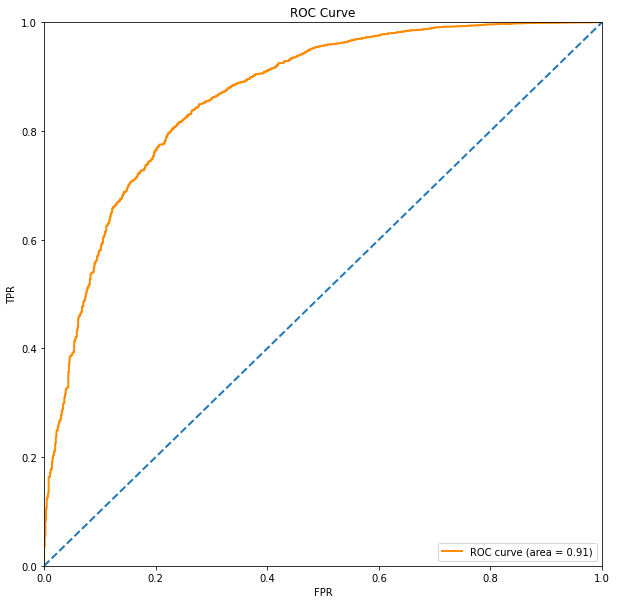

In [118]:
# Receiver Operating Characterstic

y_pred = [x[1] for x in model.predict_proba(X_test_seq)]
y_test = [x.index(1) for x in y_test_seq.tolist()]

fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)
roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {round(roc_auc,2)})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.show()

## Saving the Model

In [0]:
# Saving Tokenizer
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save model architecture by serializing to JSON
json_model = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(json_model)

# Save model weights by serializing to HDF5
model.save_weights("model.h5")

## Predicting Sentiments
A function that loads the model and its parameters and predicts the sentiment.

In [0]:
from keras.models import model_from_json
def get_sentiment(reviews,tokenizer_pickle_file='tokenizer.pickle',model_json_file='model.json',model_weights_file="model.h5",w2v_file="w2v",embed_size=300):

    assert type(reviews) == list

    w2v = Word2Vec.load(w2v_file)

    with open(tokenizer_pickle_file, 'rb') as handle:
        tokenizer = pickle.load(handle)

    json_file = open(model_json_file, 'r')
    json_model = json_file.read()
    json_file.close()
    model = model_from_json(json_model)
    model.load_weights(model_weights_file)

    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

    review_seq = tokenizer.texts_to_sequences(reviews)
    review_seq = sequence.pad_sequences(review_seq, maxlen=100)

    proba = model.predict_proba(review_seq)

    sentiments = []
    for x in proba.tolist():

        class_idx = np.argmax(x)
        sentiment = "Positive" if class_idx == 1 else "Negative"
        class_proba = x[class_idx]
        sentiments.append((sentiment,class_proba))

    return sentiments

In [145]:
reviews = list(data_df["reviewText"].sample(3))
for i in range(3):
    print(reviews[i])

This product has been tested not by me but by my kindergartner daughter who has made quite impressive advances on the writing of vocals in it. She is 3 1/2 years old and left handed.It has good set of instructions and has been very helpful. She has been doing her homework for more than a week on it.I suggest to get this notebook and have your children use it while learning writing skills and you will see the difference.
This binder is unique with it's flexible cover.  If you're really wanting a flexible cover because a hard cover will get beat up in your backpack and will feel stiff in there, this is a good choice and appears sturdy enough to last through the school year.  It's flexible enough that you can fully flip the top cover underneath so it's not spread out all over your desk as you're taking notes, too. I also like that it comes with 60 sheets of college ruled notebook paper and 20 sheets of graph paper, as well as 5 grey plastic dividers.  The dividers come with stick on label

In [146]:
get_sentiment(reviews)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[('Positive', 0.9729774594306946),
 ('Positive', 0.9723073840141296),
 ('Negative', 0.684578001499176)]